# Implementation of MAXSER

## Step 0: Subpool selection
   1. Form 1000 random subpools of $N^-$ assets
   2. Calculate the adjusted Sharpe ratio, $\hat{\theta}_{adj}$: $$\hat{\theta}_{adj} = \frac{(T-N-2)\hat{\theta}_s-N}{T}+\frac{2(\hat{\theta}_s)^{N/2}(1+\hat{\theta}_s)^{-(T-2)/2}}{TB_{\hat{\theta}_s/(1+\hat{\theta}_s)}(N/2,(T-N)/2)}$$
      where $\hat{\theta}_s$ is the sample estimate of the Sharpe ratio $$\hat{\theta}_s:=\mathbf{\hat{\mu}}'\mathbf{\hat{\Sigma}}^{-1}\mathbf{\hat{\mu}}$$
      and $$B_x(a,b) = \int_0^x y^{a-1}(1-y)^{b-1}dy$$
   3. Select the subpool with $\hat{\theta}_{adj}$ corresponding to 95th percentile.

## Step 1 
   1. Estimate the square of the maximum Sharpe ratio by $\hat{\theta}_{adj}$
   2. Compute response $$\hat{r}_c := \sigma\frac{1+\hat{\theta}}{\sqrt{\hat{\theta}}}$$
   where $\sigma$ is a given risk constraint (i.e. target risk level), and $$\hat{\theta}:=\frac{(T-N-2)\hat{\theta}_s-N}{T}$$

## Step 2
   1. Split the sample into 10 random groups and select $\lambda$ through 10-fold cross-validation:
      - For each training set $i$, obtain the whole solution path $(\mathbf{\omega}_{0≤\zeta≤1})$ (using LARS?)
      - Calculate the difference between the risk computed using the validation set and the given risk constraint
      - $\hat{\zeta}$ is taken to be the average of $\zeta(i), i = 1,\dots,10$
      - Denote selected value by $\hat{\lambda}$
   
## Step 3
   1. Use the estimated $\hat{\lambda}$ in $$\hat{\mathbf{\omega^*}} = \underset{\mathbf{\omega}}{\mathrm{argmin}}\frac{1}{T}\sum_{t=1}^T(\hat{r}_c-\mathbf{\omega}'\mathbf{R_t})^2\quad \text{subect to} \quad ||\mathbf{\omega}||_1≤\hat{\lambda}$$ and solve for the MAXSER portfolio weights $\hat{\mathbf{\omega^*}}$

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import betainc, beta
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso

data = pd.read_csv('48_Industry_Portfolios.csv', skiprows=11, nrows=1181, index_col=0)
data.index = pd.to_datetime(data.index, format='%Y%m')
data = data.iloc[-120:]      # use last 120 observations (10 years)

rf_data = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3, nrows=1181, index_col=0)
rf_data.index = pd.to_datetime(rf_data.index, format='%Y%m')
rf_data.tail()

,Mkt-RF,SMB,HML,RF
2024-07-01,1.24,6.80,5.74,0.45
2024-08-01,1.61,-3.55,-1.13,0.48
2024-09-01,1.74,-0.17,-2.59,0.40
2024-10-01,-0.97,-1.01,0.89,0.39
2024-11-01,6.50,4.63,-0.05,0.40


In [149]:
rf = 0.40                       # most recent risk free rate from factor dataset
data_excess = data - rf         # compute excess returns # convert to percentage
T, N = data.shape
data_excess.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
2014-12-01,-0.45,-1.77,-5.57,-4.76,-3.29,-3.08,-5.62,1.46,-0.32,-1.09,...,4.13,1.06,0.11,1.83,-0.89,1.57,1.47,-0.81,3.01,-1.00
2015-01-01,-1.29,-2.49,-1.52,0.48,2.67,-0.53,-0.14,-2.36,-5.01,-4.32,...,-5.06,-4.85,-2.77,-0.82,0.40,-9.82,-4.82,-0.04,-7.86,-4.86
2015-02-01,1.67,3.29,6.09,4.10,5.06,5.02,5.34,7.64,3.17,5.55,...,10.79,2.45,4.64,5.39,6.41,7.58,7.43,5.42,8.11,5.08
2015-03-01,-5.71,2.15,-5.05,-2.48,-8.87,-4.57,-2.50,0.02,-2.73,0.78,...,-3.65,-3.45,0.19,0.53,-0.65,-1.14,1.89,1.00,-0.28,-2.61
2015-04-01,0.63,-0.51,-0.83,-0.89,5.61,8.83,2.76,-4.40,-2.76,-2.05,...,-2.14,-2.01,-1.69,-3.14,0.15,1.66,-2.23,-3.68,0.13,1.24


In [150]:
# Derive a sigma value
cov_matrix = data_excess.cov()
weights = np.full(N, 1 / N)  # naive weights for all assets

var = np.dot(weights.T, np.dot(cov_matrix, weights))
sigma = np.sqrt(var).round(2)
print(sigma)


4.91


In [151]:
# functions
def B_x(x, a, b):
    return betainc(a, b, x) * beta(a, b) # did not realize betainc() was the regularized incomplete beta function

def sample_sharpe_s(returns):
    mu = np.mean(returns, axis=0)
    Sigma = np.cov(returns, rowvar=False)
    inv_Sigma = np.linalg.inv(Sigma)
    return mu.T @ inv_Sigma @ mu  # squared max Sharpe ratio estimate

def adj_sharpe_hat(theta_s, T, N):
    first_term = ((T - N - 2) * theta_s - N) / T
    second_num = 2 * (theta_s ** (N / 2)) * ((1 + theta_s) ** (-(T - 2) / 2))
    B_val = B_x(theta_s / (1 + theta_s), N / 2, (T - N) / 2)
    second_term = second_num / (T * B_val)
    theta_adj = first_term + second_term
    return theta_adj

In [152]:
# Step 0: Subpool selection
n_subpools = 1000
subpool_size = 5 # in keeping with other parts of assignment
subpool_adj_sharpes = []
subpool_indices = []

np.random.seed(60202)

for _ in range(n_subpools):
    selected_cols = np.random.choice(data_excess.columns, subpool_size, replace=False)
    sub_data = data_excess[selected_cols].values
    theta_s = sample_sharpe_s(sub_data)
    theta_adj = adj_sharpe_hat(theta_s, T, subpool_size)
    subpool_adj_sharpes.append(theta_adj)
    subpool_indices.append(selected_cols)

threshold = np.percentile(subpool_adj_sharpes, 95)
candidate_indices = np.where(np.array(subpool_adj_sharpes) >= threshold)[0]
best_idx = candidate_indices[0]  # first that meets or exceeds 95th percentile
best_subpool = subpool_indices[best_idx]
print("Selected industries:", best_subpool)
# assign sharpe corresponding to best subpool
best_sharpe = subpool_adj_sharpes[best_idx]
print("Best adjusted Sharpe ratio:", best_sharpe)

Selected industries: ['Rtail' 'Mach ' 'Paper' 'BusSv' 'MedEq']
Best adjusted Sharpe ratio: 0.06059081090802175


In [153]:
# Step 1: Compute r_c
r_c = sigma * (1 + best_sharpe) / np.sqrt(best_sharpe)
print(r_c)

21.15563033446536


In [154]:
# Step 2: 10-fold CV to select lambda
X = sub_data
y = np.full(T, r_c)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
alphas = np.logspace(-3, 2, 50)  # grid of alpha values

best_alpha = None
best_score = np.inf

for alpha in alphas:
    cv_scores = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        lasso = Lasso(alpha=alpha, fit_intercept=False)
        lasso.fit(X_train, y_train)
        w = lasso.coef_
        
        # Compute risk on validation set and compare to sigma
        port_ret = X_val @ w
        port_risk = np.std(port_ret)
        cv_scores.append(abs(port_risk - sigma))
    
    avg_score = np.mean(cv_scores)
    if avg_score < best_score:
        best_score = avg_score
        best_alpha = alpha

lambda_hat = best_alpha
print(lambda_hat)

0.001


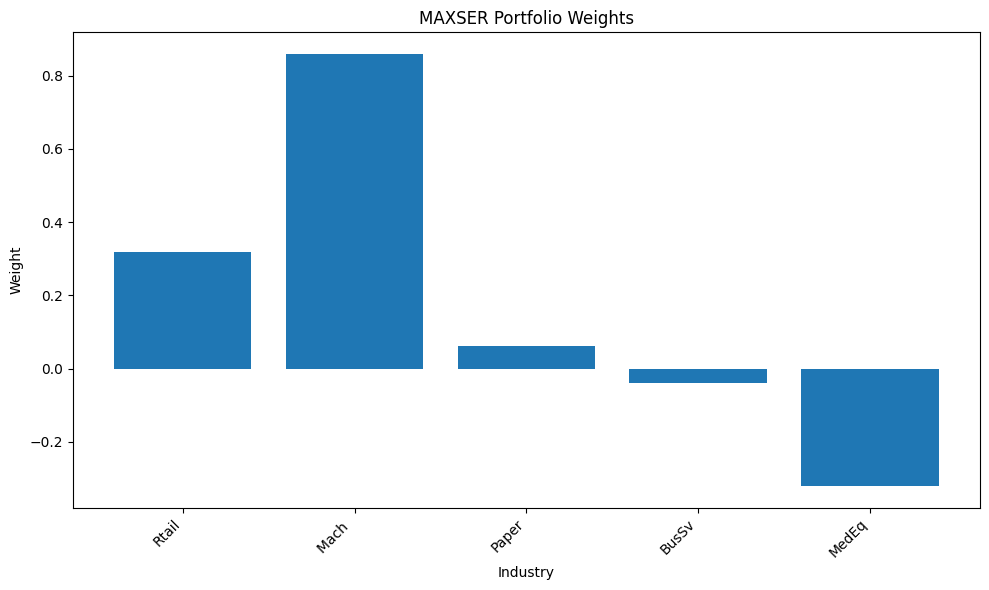

         Weight
Rtail  0.317850
Mach   0.859634
Paper  0.060993
BusSv -0.038238
MedEq -0.320784


In [155]:
# Step 3: Solve for final weights with selected lambda
final_lasso = Lasso(alpha=lambda_hat, fit_intercept=False)
final_lasso.fit(X, y)
w_star = final_lasso.coef_

# Plot the weights
plt.figure(figsize=(10, 6))
plt.bar(best_subpool, w_star)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Industry')
plt.ylabel('Weight')
plt.title('MAXSER Portfolio Weights')
plt.tight_layout()
plt.show()

# Print table of portfolio weights
weights_df = pd.DataFrame(w_star, index=best_subpool, columns=['Weight'])

print(weights_df)